## PROYECTO 1 - MINERIA DE DATOS

In [2]:
# Importando librerias necesarias
import pandas as pd
# Graficar
import matplotlib.pyplot as plt
# Verificar distribución normal
import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.stats.diagnostic as diag
import statsmodels.api as sm
# Para complementar analisis exploratorio
import seaborn as sns
# Para clustering
import random, sklearn, pyclustertend
import sklearn.cluster as cluster

In [3]:
# Cargando el data
data_2017 = pd.read_spss('matrimonio2017.sav')
data_2017 = pd.DataFrame(data_2017)

data_2018 = pd.read_spss('matrimonio2018.sav')
data_2018 = pd.DataFrame(data_2018)

data_2019 = pd.read_spss('matrimonio2019.sav')
data_2019 = pd.DataFrame(data_2019)

data_2020 = pd.read_spss('matrimonio2020.sav')
data_2020 = pd.DataFrame(data_2020)

data_2021 = pd.read_spss('matrimonio2021.sav')
data_2021 = pd.DataFrame(data_2021)


In [4]:
from utils import *

# Data de importancia
ocupacion_tipos_basico = get_ocupaciones_info()

departamentos_2011_2019 = {'Alta Verapaz': 1, 'Baja Verapaz': 2, 'Chimaltenango': 3, 'Chiquimula': 4, 'El Progreso': 5, 'Escuintla': 6, 'Guatemala': 7,
                           'Huehuetenango': 8, 'Izabal': 9, 'Jalapa': 10, 'Jutiapa': 11, 'Peten': 12, 'Quetzaltenango': 13, 'Quiche': 14, 'Retalhuleu': 15,
                           'Sacatepequez': 16, 'San Marcos': 17, 'Santa Rosa': 18, 'Solola': 19, 'Suchitepequez': 20, 'Totonicapan': 21, 'Zacapa': 22}

meses_ocurrencia = {'Enero':1, 'Febrero':2, 'Marzo':3, 'Abril': 4, 'Mayo': 5, 'Junio': 6, 'Julio': 7, 'Agosto': 8, 'Septiembre': 9, 'Octubre': 10, 
                    'Noviembre': 11, 'Diciembre': 12}

mas_ocupaciones = ocupacion_tipos_basico.copy()
mas_ocupaciones['Suboficiales de las fuerzas armadas'] = 22
mas_ocupaciones['Trabajadores forestales calificados, pescadores y cazadores'] = 41


In [5]:
# Limpieza data - 2017

columns_use_2017 = []

# Uso de data solamente de personas guatemaltecas
data_2017 = data_2017[data_2017['NACHOM'] == 'Guatemala']
data_2017 = data_2017[data_2017['NACMUJ'] == 'Guatemala']

# Clase de union en matrimonio
union_tipos_2017 = {'Comunidad de gananciales': 1, 'Comunidad absoluta': 2, 'Separación absoluta': 3}
data_2017['claseUnion'] = data_2017['CLAUNI'].apply(lambda x: union_tipos_2017.get(x, 0))
columns_use_2017.append('claseUnion')

# Grupo etnico de hombre
grupos_etnicos_hombre_2017 = {'Ladino / Mestizo': 1, 'Maya': 2, 'Garífuna': 3, 'Xinca': 4}
data_2017['grupoEtnicoHombre'] = data_2017['PUEHOM'].apply(lambda x: grupos_etnicos_hombre_2017.get(x, 0))
columns_use_2017.append('grupoEtnicoHombre')

# Grupo etnico de mujer
grupos_etnicos_mujer_2017 = {'Mestizo / Ladino': 1, 'Maya': 2, 'Garífuna': 3, 'Xinca': 4}
data_2017['grupoEtnicoMujer'] = data_2017['PUEMUJ'].apply(lambda x: grupos_etnicos_mujer_2017.get(x, 0))
columns_use_2017.append('grupoEtnicoMujer')

# Edad del hombre
data_2017['edadHombre'] = data_2017['EDADHOM']
columns_use_2017.append('edadHombre')

# Edad de la mujer
data_2017['edadMujer'] = data_2017['EDADMUJ']
columns_use_2017.append('edadMujer')

# Nivel de educacion del hombre y de la mujer
educacion_tipos_2017 = {'Ninguno': 1, 'Primaria': 2, 'Básico': 3, 'Diversificado': 4, 'Universitario': 5, 'Postgrado': 6}
data_2017['educacionHombre'] = data_2017['ESCHOM'].apply(lambda x: educacion_tipos_2017.get(x, 0))
data_2017['educacionMujer'] = data_2017['ESCMUJ'].apply(lambda x: educacion_tipos_2017.get(x, 0))
columns_use_2017.extend(['educacionHombre', 'educacionMujer'])

# Oficio del hombre
data_2017['ocupacionHombre'] = data_2017['CIUOHOM'].apply(lambda x: mas_ocupaciones.get(x, 0))
columns_use_2017.append('ocupacionHombre')

# Oficio de la mujer
data_2017['ocupacionMujer'] = data_2017['CIUOMUJ'].apply(lambda x: ocupacion_tipos_basico.get(x, 0))
columns_use_2017.append('ocupacionMujer')

# Departamento de ocurrencia de matrimonio
data_2017['departamentoOcurrencia'] = data_2017['DEPREG'].apply(lambda x: departamentos_2011_2019.get(x, 0))
columns_use_2017.append('departamentoOcurrencia')

# Mes de ocurrencia de matrimonio
data_2017['mesOcurrencia'] = data_2017['MESREG'].apply(lambda x: meses_ocurrencia.get(x, 0))
columns_use_2017.append('mesOcurrencia')

# Año de registro de matrimonio
data_2017['anioRegistro'] = data_2017['AÑOREG']
columns_use_2017.append('anioRegistro')

# data final - 2017
columns_not_used_2017 = [x for x in data_2017.columns if x not in columns_use_2017]
data_2017_final = data_2017.drop(columns_not_used_2017, axis=1)

data_2017_final


,claseUnion,grupoEtnicoHombre,grupoEtnicoMujer,edadHombre,edadMujer,educacionHombre,educacionMujer,ocupacionHombre,ocupacionMujer,departamentoOcurrencia,mesOcurrencia,anioRegistro
0,1,0,0,19.0,19.0,0,0,0,0,14,9,2017.0
1,1,0,0,19.0,19.0,0,0,0,0,14,4,2017.0
2,1,0,0,19.0,19.0,0,0,0,0,14,4,2017.0
3,1,0,0,18.0,19.0,0,0,0,0,19,5,2017.0
4,1,0,0,18.0,19.0,0,0,0,0,21,2,2017.0
...,...,...,...,...,...,...,...,...,...,...,...,...
71591,1,1,1,50.0,42.0,4,5,31,6,7,6,2017.0
71592,2,1,1,22.0,21.0,4,5,29,6,7,2,2017.0
71594,3,0,1,25.0,25.0,5,5,6,6,7,1,2018.0
71595,1,0,1,26.0,26.0,4,4,14,22,16,1,2018.0


In [6]:
# Limpieza data - 2018

columns_use_2018 = []

# Uso de data solamente de personas guatemaltecas
data_2018 = data_2018[data_2018['NACHOM'] == 'Guatemala']
data_2018 = data_2018[data_2018['NACMUJ'] == 'Guatemala']

# Clase de union en matrimonio
union_tipos_2018 = {'Comunidad de gananciales': 1, 'Comunidad absoluta': 2, 'Separación absoluta': 3}
data_2018['claseUnion'] = data_2018['CLAUNI'].apply(lambda x: union_tipos_2018.get(x, 0))
columns_use_2018.append('claseUnion')

# Grupo etnico de hombre y mujer
grupos_etnicos_2018 = {'Ladino / Mestizo': 1, 'Maya': 2, 'Garífuna': 3, 'Xinca': 4}
data_2018['grupoEtnicoHombre'] = data_2018['PUEHOM'].apply(lambda x: grupos_etnicos_2018.get(x, 0))
data_2018['grupoEtnicoMujer'] = data_2018['PUEMUJ'].apply(lambda x: grupos_etnicos_2018.get(x, 0))
columns_use_2018.extend(['grupoEtnicoMujer', 'grupoEtnicoHombre'])

# Edad del hombre
data_2018['edadHombre'] = data_2018['EDADHOM']
columns_use_2018.append('edadHombre')

# Edad de la mujer
data_2018['edadMujer'] = data_2018['EDADMUJ']
columns_use_2018.append('edadMujer')

# Nivel de educacion del hombre y de la mujer
educacion_tipos_2018 = {'Ninguno': 1, 'Primaria': 2, 'Básico': 3, 'Diversificado': 4, 'Universitario': 5, 'Post Grado': 6}
data_2018['educacionHombre'] = data_2018['ESCHOM'].apply(lambda x: educacion_tipos_2018.get(x, 0))
data_2018['educacionMujer'] = data_2018['ESCMUJ'].apply(lambda x: educacion_tipos_2018.get(x, 0))
columns_use_2018.extend(['educacionHombre', 'educacionMujer'])

# Oficio del hombre
data_2018['ocupacionHombre'] = data_2018['CIUOHOM'].apply(lambda x: mas_ocupaciones.get(x, 0))
columns_use_2018.append('ocupacionHombre')

# Oficio de la mujer
data_2018['ocupacionMujer'] = data_2018['CIUOMUJ'].apply(lambda x: ocupacion_tipos_basico.get(x, 0))
columns_use_2018.append('ocupacionMujer')

# Departamento de ocurrencia de matrimonio
data_2018['departamentoOcurrencia'] = data_2018['DEPREG'].apply(lambda x: departamentos_2011_2019.get(x, 0))
columns_use_2018.append('departamentoOcurrencia')

# Mes de ocurrencia de matrimonio
data_2018['mesOcurrencia'] = data_2018['MESREG'].apply(lambda x: meses_ocurrencia.get(x, 0))
columns_use_2018.append('mesOcurrencia')

# Año de registro de matrimonio
data_2018['anioRegistro'] = data_2018['AÑOREG']
columns_use_2018.append('anioRegistro')

# data final - 2018
columns_not_used_2018 = [x for x in data_2018.columns if x not in columns_use_2018]
data_2018_final = data_2018.drop(columns_not_used_2018, axis=1)

data_2018_final


,claseUnion,grupoEtnicoHombre,grupoEtnicoMujer,edadHombre,edadMujer,educacionHombre,educacionMujer,ocupacionHombre,ocupacionMujer,departamentoOcurrencia,mesOcurrencia,anioRegistro
1,2,1,1,30.0,31.0,4,4,14,31,7,1,2018.0
2,1,1,1,59.0,51.0,1,1,39,39,7,1,2018.0
3,3,3,3,25.0,23.0,4,4,14,39,7,1,2018.0
5,1,1,1,26.0,20.0,4,4,31,31,7,1,2018.0
6,1,0,1,49.0,23.0,2,3,14,14,7,1,2018.0
...,...,...,...,...,...,...,...,...,...,...,...,...
74771,1,1,1,23.0,27.0,1,3,23,14,11,1,2019.0
74772,1,1,0,23.0,21.0,3,2,14,14,11,1,2019.0
74773,2,1,1,18.0,18.0,3,4,23,14,11,1,2019.0
74774,1,1,1,37.0,20.0,4,4,32,14,11,1,2019.0


In [7]:
# Limpieza data - 2019

columns_use_2019 = []

# Uso de data solamente de personas guatemaltecas
data_2019 = data_2019[data_2019['NACHOM'] == 'Guatemala']
data_2019 = data_2019[data_2019['NACMUJ'] == 'Guatemala']

# Clase de union en matrimonio
union_tipos_2019 = {'Comunidad de gananciales': 1, 'Comunidad absoluta': 2, 'Separación absoluta': 3}
data_2019['claseUnion'] = data_2019['CLAUNI'].apply(lambda x: union_tipos_2019.get(x, 0))
columns_use_2019.append('claseUnion')

# Grupo etnico de hombre y mujer
grupos_etnicos_2019 = {'Ladino / Mestizo': 1, 'Maya': 2, 'Garífuna': 3, 'Xinca': 4}
data_2019['grupoEtnicoHombre'] = data_2019['PUEHOM'].apply(lambda x: grupos_etnicos_2019.get(x, 0))
data_2019['grupoEtnicoMujer'] = data_2019['PUEMUJ'].apply(lambda x: grupos_etnicos_2019.get(x, 0))
columns_use_2019.extend(['grupoEtnicoMujer', 'grupoEtnicoHombre'])

# Edad del hombre
data_2019['edadHombre'] = data_2019['EDADHOM']
columns_use_2019.append('edadHombre')

# Edad de la mujer
data_2019['edadMujer'] = data_2019['EDADMUJ']
columns_use_2019.append('edadMujer')

# Nivel de educacion del hombre y de la mujer
educacion_tipos_2019 = {'Ninguno': 1, 'Primaria': 2, 'Básico': 3, 'Diversificado': 4, 'Universitario': 5, 'Post Grado': 6}
data_2019['educacionHombre'] = data_2019['ESCHOM'].apply(lambda x: educacion_tipos_2019.get(x, 0))
data_2019['educacionMujer'] = data_2019['ESCMUJ'].apply(lambda x: educacion_tipos_2019.get(x, 0))
columns_use_2019.extend(['educacionHombre', 'educacionMujer'])

# Oficio del hombre
data_2019['ocupacionHombre'] = data_2019['CIUOHOM'].apply(lambda x: mas_ocupaciones.get(x, 0))
columns_use_2019.append('ocupacionHombre')

# Oficio de la mujer
data_2019['ocupacionMujer'] = data_2019['CIUOMUJ'].apply(lambda x: ocupacion_tipos_basico.get(x, 0))
columns_use_2019.append('ocupacionMujer')

# Departamento de ocurrencia de matrimonio
data_2019['departamentoOcurrencia'] = data_2019['DEPREG'].apply(lambda x: departamentos_2011_2019.get(x, 0))
columns_use_2019.append('departamentoOcurrencia')

# Mes de ocurrencia de matrimonio
data_2019['mesOcurrencia'] = data_2019['MESREG'].apply(lambda x: meses_ocurrencia.get(x, 0))
columns_use_2019.append('mesOcurrencia')

# Año de registro de matrimonio
data_2019['anioRegistro'] = data_2019['AÑOREG']
columns_use_2019.append('anioRegistro')

# data final - 2019
columns_not_used_2019 = [x for x in data_2019.columns if x not in columns_use_2019]
data_2019_final = data_2019.drop(columns_not_used_2019, axis=1)

data_2019_final


,claseUnion,grupoEtnicoHombre,grupoEtnicoMujer,edadHombre,edadMujer,educacionHombre,educacionMujer,ocupacionHombre,ocupacionMujer,departamentoOcurrencia,mesOcurrencia,anioRegistro
0,1,1,1,28.0,35.0,4,5,14,15,7,9,2019.0
1,2,1,1,26.0,27.0,4,4,25,15,10,8,2019.0
2,1,1,1,47.0,31.0,6,5,14,6,7,9,2019.0
3,1,0,1,26.0,36.0,3,5,14,6,7,12,2019.0
5,1,1,1,32.0,36.0,5,5,14,6,1,8,2019.0
...,...,...,...,...,...,...,...,...,...,...,...,...
76922,1,1,0,34.0,26.0,4,0,26,0,6,12,2019.0
76924,1,2,0,30.0,28.0,4,0,26,0,14,9,2019.0
76925,1,1,0,30.0,29.0,4,0,26,0,7,1,2020.0
76926,1,1,1,44.0,39.0,5,4,28,0,4,12,2019.0


In [8]:

departamentos_2020_2021 = {'Alta Verapaz': 1, 'Baja Verapaz': 2, 'Chimaltenango': 3, 'Chiquimula': 4, 'El Progreso': 5, 'Escuintla': 6, 'Guatemala': 7, 'Huehuetenango': 8,
                            'Izabal': 9, 'Jalapa': 10, 'Jutiapa': 11, 'Petén': 12, 'Quetzaltenango': 13, 'Quiché': 14, 'Retalhuleu': 15, 'Sacatepéquez': 16, 'San Marcos': 17,
                            'Santa Rosa': 18, 'Sololá': 19, 'Suchitepéquez': 20, 'Totonicapán': 21, 'Zacapa': 22}


In [9]:
# Limpieza data - 2020

columns_use_2020 = []

# Uso de data solamente de personas guatemaltecas
data_2020 = data_2020[data_2020['NACHOM'] == 'Guatemala']
data_2020 = data_2020[data_2020['NACMUJ'] == 'Guatemala']

# Clase de union en matrimonio
union_tipos_2020 = {'Comunidad de gananciales': 1, 'Comunidad absoluta': 2, 'Separación absoluta': 3}
data_2020['claseUnion'] = data_2020['CLAUNI'].apply(lambda x: union_tipos_2020.get(x, 0))
columns_use_2020.append('claseUnion')

# Grupo etnico de hombre y mujer
grupos_etnicos_2020 = {'Ladino / Mestizo': 1, 'Maya': 2, 'Garífuna': 3, 'Xinka': 4}
data_2020['grupoEtnicoHombre'] = data_2020['PUEHOM'].apply(lambda x: grupos_etnicos_2020.get(x, 0))
data_2020['grupoEtnicoMujer'] = data_2020['PUEMUJ'].apply(lambda x: grupos_etnicos_2020.get(x, 0))
columns_use_2020.extend(['grupoEtnicoMujer', 'grupoEtnicoHombre'])

# Edad del hombre
data_2020['edadHombre'] = data_2020['EDADHOM']
columns_use_2020.append('edadHombre')

# Edad de la mujer
data_2020['edadMujer'] = data_2020['EDADMUJ']
columns_use_2020.append('edadMujer')

# Nivel de educacion del hombre y de la mujer
educacion_tipos_2020 = {'Ninguno': 1, 'Primaria': 2, 'Básico': 3, 'Diversificado': 4, 'Universitario': 5, 'Post Grado': 6}
data_2020['educacionHombre'] = data_2020['ESCHOM'].apply(lambda x: educacion_tipos_2020.get(x, 0))
data_2020['educacionMujer'] = data_2020['ESCMUJ'].apply(lambda x: educacion_tipos_2020.get(x, 0))
columns_use_2020.extend(['educacionHombre', 'educacionMujer'])

# Oficio del hombre
data_2020['ocupacionHombre'] = data_2020['CIUOHOM'].apply(lambda x: mas_ocupaciones.get(x, 0))
columns_use_2020.append('ocupacionHombre')

# Oficio de la mujer
data_2020['ocupacionMujer'] = data_2020['CIUOMUJ'].apply(lambda x: ocupacion_tipos_basico.get(x, 0))
columns_use_2020.append('ocupacionMujer')

# Departamento de ocurrencia de matrimonio
data_2020['departamentoOcurrencia'] = data_2020['DEPREG'].apply(lambda x: departamentos_2020_2021.get(x, 0))
columns_use_2020.append('departamentoOcurrencia')

# Mes de ocurrencia de matrimonio
data_2020['mesOcurrencia'] = data_2020['MESREG'].apply(lambda x: meses_ocurrencia.get(x, 0))
columns_use_2020.append('mesOcurrencia')

# Año de registro de matrimonio
data_2020['anioRegistro'] = data_2020['AÑOREG']
columns_use_2020.append('anioRegistro')

# data final - 2020
columns_not_used_2020 = [x for x in data_2020.columns if x not in columns_use_2020]
data_2020_final = data_2020.drop(columns_not_used_2020, axis=1)

data_2020_final


,claseUnion,grupoEtnicoHombre,grupoEtnicoMujer,edadHombre,edadMujer,educacionHombre,educacionMujer,ocupacionHombre,ocupacionMujer,departamentoOcurrencia,mesOcurrencia,anioRegistro
0,1,1,1,33.0,33.0,4,4,15,15,7,2,2021.0
1,1,0,1,30.0,31.0,4,4,15,15,7,4,2021.0
3,1,1,1,27.0,34.0,4,5,14,5,7,8,2020.0
4,1,1,1,54.0,47.0,3,5,14,5,7,8,2020.0
6,1,1,1,29.0,42.0,4,0,14,5,7,2,2020.0
...,...,...,...,...,...,...,...,...,...,...,...,...
57381,1,2,0,19.0,23.0,4,0,26,0,1,2,2020.0
57382,1,1,0,28.0,18.0,4,0,26,0,1,10,2020.0
57383,1,1,0,31.0,29.0,4,0,26,0,12,8,2020.0
57385,2,1,0,39.0,32.0,5,0,15,0,16,6,2020.0


In [10]:
# Limpieza data - 2021

columns_use_2021 = []

# Uso de data solamente de personas guatemaltecas
data_2021 = data_2021[data_2021['NACHOM'] == 'Guatemala']
data_2021 = data_2021[data_2021['NACMUJ'] == 'Guatemala']

# Clase de union en matrimonio
union_tipos_2021 = {'Comunidad de gananciales': 1, 'Comunidad absoluta': 2, 'Separación absoluta': 3}
data_2021['claseUnion'] = data_2021['CLAUNI'].apply(lambda x: union_tipos_2021.get(x, 0))
columns_use_2021.append('claseUnion')

# Grupo etnico de hombre y mujer
grupos_etnicos_2021 = {'Ladino / Mestizo': 1, 'Maya': 2, 'Garífuna': 3, 'Xinka': 4}
data_2021['grupoEtnicoHombre'] = data_2021['PUEHOM'].apply(lambda x: grupos_etnicos_2021.get(x, 0))
data_2021['grupoEtnicoMujer'] = data_2021['PUEMUJ'].apply(lambda x: grupos_etnicos_2021.get(x, 0))
columns_use_2021.extend(['grupoEtnicoMujer', 'grupoEtnicoHombre'])

# Edad del hombre
data_2021['edadHombre'] = data_2021['EDADHOM']
columns_use_2021.append('edadHombre')

# Edad de la mujer
data_2021['edadMujer'] = data_2021['EDADMUJ']
columns_use_2021.append('edadMujer')

# Nivel de educacion del hombre y de la mujer
educacion_tipos_2021 = {'Ninguno': 1, 'Primaria': 2, 'Básico': 3, 'Diversificado': 4, 'Universitario': 5, 'Post Grado': 6}
data_2021['educacionHombre'] = data_2021['ESCHOM'].apply(lambda x: educacion_tipos_2021.get(x, 0))
data_2021['educacionMujer'] = data_2021['ESCMUJ'].apply(lambda x: educacion_tipos_2021.get(x, 0))
columns_use_2021.extend(['educacionHombre', 'educacionMujer'])

# Oficio del hombre
data_2021['ocupacionHombre'] = data_2021['CIUOHOM'].apply(lambda x: mas_ocupaciones.get(x, 0))
columns_use_2021.append('ocupacionHombre')

# Oficio de la mujer
data_2021['ocupacionMujer'] = data_2021['CIUOMUJ'].apply(lambda x: ocupacion_tipos_basico.get(x, 0))
columns_use_2021.append('ocupacionMujer')

# Departamento de ocurrencia de matrimonio
data_2021['departamentoOcurrencia'] = data_2021['DEPREG'].apply(lambda x: departamentos_2020_2021.get(x, 0))
columns_use_2021.append('departamentoOcurrencia')

# Mes de ocurrencia de matrimonio
data_2021['mesOcurrencia'] = data_2021['MESREG'].apply(lambda x: meses_ocurrencia.get(x, 0))
columns_use_2021.append('mesOcurrencia')

# Año de registro de matrimonio
data_2021['anioRegistro'] = data_2021['AÑOREG']
columns_use_2021.append('anioRegistro')

# data final - 2021
columns_not_used_2021 = [x for x in data_2021.columns if x not in columns_use_2021]
data_2021_final = data_2021.drop(columns_not_used_2021, axis=1)

data_2021_final


,claseUnion,grupoEtnicoHombre,grupoEtnicoMujer,edadHombre,edadMujer,educacionHombre,educacionMujer,ocupacionHombre,ocupacionMujer,departamentoOcurrencia,mesOcurrencia,anioRegistro
0,1,2,2,18.0,18.0,4,4,26,14,21,10,2021.0
1,1,1,1,18.0,19.0,4,4,26,14,17,6,2021.0
2,1,0,2,18.0,18.0,1,3,34,14,21,11,2021.0
3,1,2,2,18.0,21.0,2,2,34,39,19,6,2021.0
4,1,2,2,18.0,18.0,4,4,29,30,17,8,2021.0
...,...,...,...,...,...,...,...,...,...,...,...,...
87475,1,1,0,94.0,54.0,2,2,14,14,7,4,2021.0
87476,1,1,1,95.0,69.0,1,1,23,14,18,7,2021.0
87477,1,1,1,95.0,69.0,1,1,23,14,20,8,2021.0
87478,2,1,1,98.0,72.0,2,2,34,14,7,10,2021.0


In [11]:
# Uniendo data de 2017 a 2021
data_final = pd.concat([data_2017_final, data_2018_final, data_2019_final, data_2020_final, data_2021_final])

# Borrar toda la data que no tenga data valida
data_final.drop(data_final.index[data_final['edadHombre'] == "Ignorado"], inplace=True)
data_final.drop(data_final.index[data_final['edadMujer'] == "Ignorado"], inplace=True)
data_final.drop(data_final.index[data_final['anioRegistro'] == "Ignorado"], inplace=True)

# Borrando las filas que tengan algun valor igual a 0
data_final = data_final[(data_final != 0).all(1)]

data_final

,claseUnion,grupoEtnicoHombre,grupoEtnicoMujer,edadHombre,edadMujer,educacionHombre,educacionMujer,ocupacionHombre,ocupacionMujer,departamentoOcurrencia,mesOcurrencia,anioRegistro
572,1,1,1,70.0,60.0,4,5,14,14,13,9,2017.0
573,1,1,1,73.0,58.0,4,5,14,14,15,11,2017.0
575,2,1,1,70.0,66.0,3,2,14,14,7,10,2017.0
576,2,1,1,64.0,69.0,2,3,14,14,9,9,2017.0
577,1,1,1,72.0,71.0,2,1,14,14,13,1,2018.0
...,...,...,...,...,...,...,...,...,...,...,...,...
87474,1,1,1,94.0,50.0,4,3,14,36,20,5,2021.0
87476,1,1,1,95.0,69.0,1,1,23,14,18,7,2021.0
87477,1,1,1,95.0,69.0,1,1,23,14,20,8,2021.0
87478,2,1,1,98.0,72.0,2,2,34,14,7,10,2021.0


### a) Descripción variables cualitativas y cuantitativas

In [12]:
# Distribución de los datos en las variables cuantitativas
data_final.describe()

,grupoEtnicoHombre,grupoEtnicoMujer,educacionHombre,educacionMujer,ocupacionHombre,ocupacionMujer,anioRegistro
count,292834.000000,292834.000000,292834.000000,292834.000000,292834.000000,292834.000000,292834.000000
mean,1.416202,1.415689,2.800443,2.709860,21.681256,16.337662,2019.083822
std,0.498084,0.501441,1.081752,1.130724,8.394367,6.418860,1.475312
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2017.000000
25%,1.000000,1.000000,2.000000,2.000000,14.000000,14.000000,2018.000000
50%,1.000000,1.000000,3.000000,3.000000,23.000000,14.000000,2019.000000
75%,2.000000,2.000000,4.000000,4.000000,23.000000,14.000000,2020.000000
max,4.000000,4.000000,6.000000,6.000000,41.000000,40.000000,2022.000000


### b) Resumen de las variables numéricas e investigar si siguien una distribución normal y tablas de frecuencia para las variables categóricas.

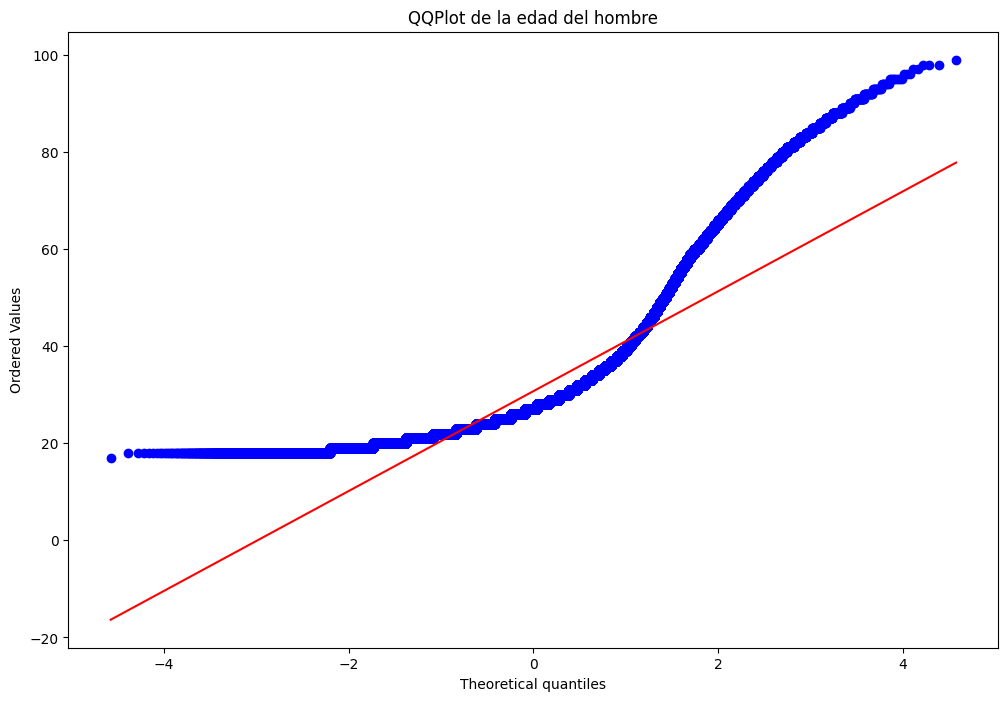

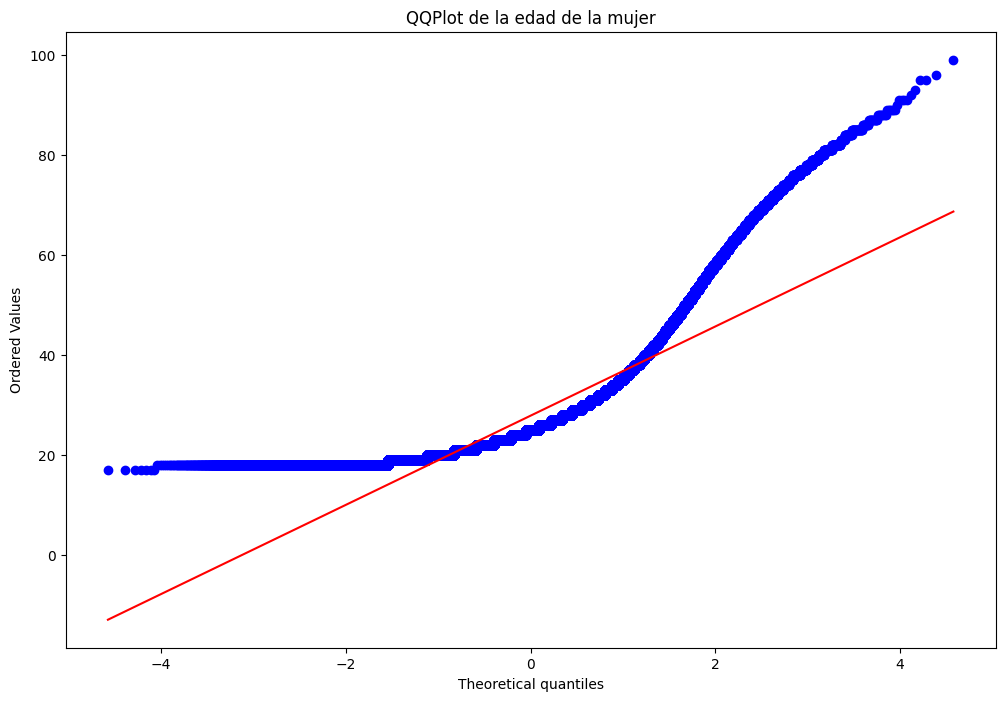

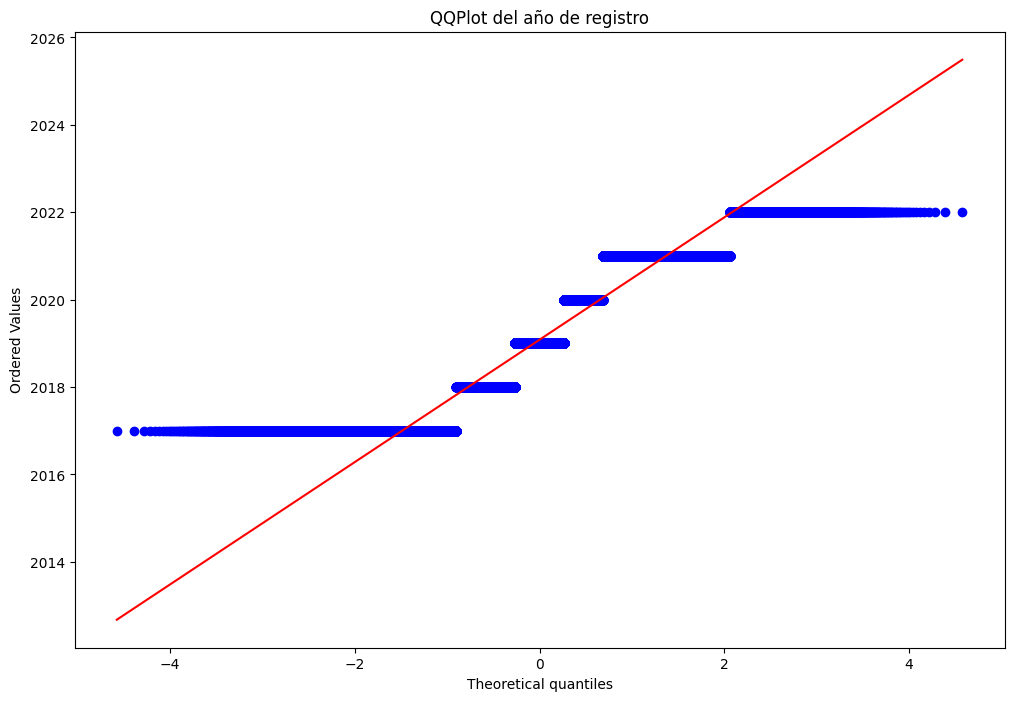

In [13]:
## qqplot de la edad del hombre# from scipy.stats import norm, probplot, kstest

# qqplot de la edad del hombre
fig, ax = plt.subplots(figsize=(12,8))
data_final['edadHombre'] = data_final['edadHombre'].astype(int)
stats.probplot(data_final['edadHombre'], plot=plt)
plt.title("QQPlot de la edad del hombre")
plt.show()

# qqplot de la edad de la mujer
fig, ax = plt.subplots(figsize=(12,8))
data_final['edadMujer'] = data_final['edadMujer'].astype(int)
stats.probplot(data_final['edadMujer'], plot=plt)
plt.title("QQPlot de la edad de la mujer")
plt.show()

# qqplot del año de registro
fig, ax = plt.subplots(figsize=(12,8))
data_final['anioRegistro'] = data_final['anioRegistro'].astype(int)
stats.probplot(data_final['anioRegistro'], plot=plt)
plt.title("QQPlot del año de registro")
plt.show()




In [14]:
# Se llevaran a cabo pruebas de normalidad con:
# *******Shapiro-Wilks*******

_, p_value = stats.shapiro(data_final[["ocupacionHombre"]].dropna())
print(f"Ocupacion Hombre: [p={p_value}]")

_, p_value = stats.shapiro(data_final[["educacionHombre"]].dropna())
print(f"Educacion Hombre: [p={p_value}]")

_, p_value = stats.shapiro(data_final[["grupoEtnicoHombre"]].dropna())
print(f"Grupo Etnico Hombre: [p={p_value}]")

_, p_value = stats.shapiro(data_final[["anioRegistro"]].dropna())
print(f"Año Registro: [p={p_value}]")

Ocupacion Hombre: [p=0.0]
Educacion Hombre: [p=0.0]
Grupo Etnico Hombre: [p=0.0]
Año Registro: [p=0.0]


/home/crislay/.local/lib/python3.10/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/home/crislay/.local/lib/python3.10/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/home/crislay/.local/lib/python3.10/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/home/crislay/.local/lib/python3.10/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


### c) Variables que son consideradas las más importantes para hallar elementos clave (Queries)

In [15]:
# Departamento de registro ocurrencia
data_final['departamentoOcurrencia'].value_counts()

7     50760
1     24450
8     22493
14    19974
17    19627
13    18360
3     14650
6     14591
20    12650
12    12598
21     9985
11     9261
19     8673
15     8041
9      7521
18     7430
4      6523
16     6099
10     5703
2      5222
22     4701
5      3522
Name: departamentoOcurrencia, dtype: int64

In [16]:
# Grupo etnico del hombre y la mujer
result_man = data_final['grupoEtnicoHombre'].value_counts()
result_woman = data_final['grupoEtnicoMujer'].value_counts()

print(f"=> Grupo etnico hombre:\n{result_man}")
print(f"\n=> Grupo etnico mujer:\n{result_woman}")

=> Grupo etnico hombre:
1    171476
2    121066
4       228
3        64
Name: grupoEtnicoHombre, dtype: int64

=> Grupo etnico mujer:
1    171961
2    120415
4       397
3        61
Name: grupoEtnicoMujer, dtype: int64


In [30]:
# Registros donde la edad del hombre o de la mujer es menor de 18 años
data_final[(data_final['edadHombre'] < 18) | (data_final['edadMujer'] < 18)]

,claseUnion,grupoEtnicoHombre,grupoEtnicoMujer,edadHombre,edadMujer,educacionHombre,educacionMujer,ocupacionHombre,ocupacionMujer,departamentoOcurrencia,mesOcurrencia,anioRegistro
8734,1,2,2,17,22,1,3,14,14,19,9,2017
8788,1,2,2,19,17,1,1,14,14,19,3,2017
10442,1,1,1,22,17,2,1,23,14,12,1,2017
17160,1,2,2,19,17,3,1,14,14,19,6,2017
32655,1,2,2,26,17,2,1,23,14,19,6,2017
48827,1,2,2,24,17,3,1,39,14,13,5,2017
58073,1,2,2,18,17,2,2,39,39,14,5,2017
61987,1,1,1,21,17,4,4,38,18,17,6,2017


In [18]:
# Edad promedio del hombre y de la mujer en los matrimonios registrados en zonas rurales o comunidades indígenas
mean_age_man = data_final['edadHombre'].mean()
mean_age_woman = data_final['edadMujer'].mean()

print(f"Edad promedio del hombre: {mean_age_man}")
print(f"Edad promedio de la mujer: {mean_age_woman}")

Edad promedio del hombre: 30.732554962879995
Edad promedio de la mujer: 27.832751661350798


### d) Gráficos exploratorios

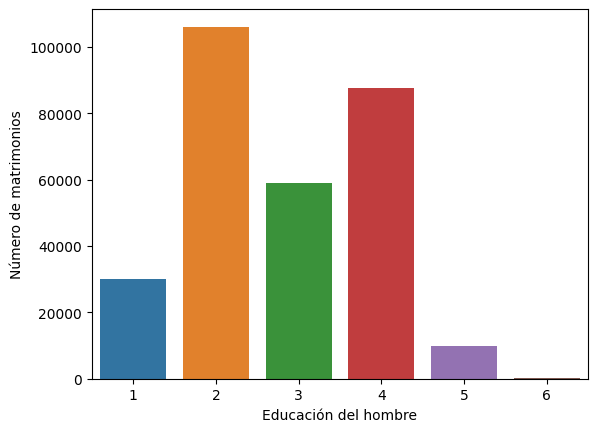

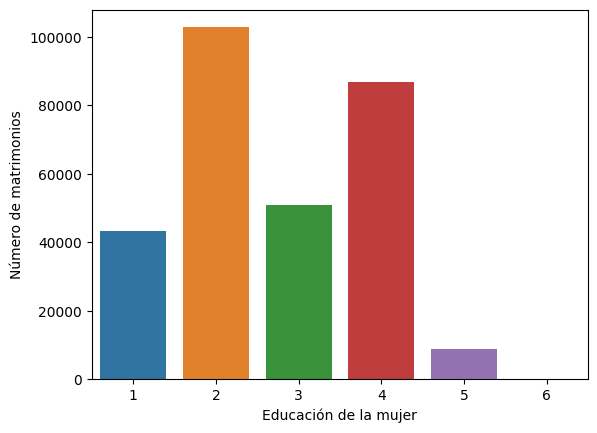

In [19]:
# Distribución de la educación y ocupación de los hombres y mujeres en los matrimonios registrados en zonas rurales o comunidades indígenas
sns.countplot(x='educacionHombre', data=data_final)
plt.xlabel('Educación del hombre')
plt.ylabel('Número de matrimonios')
plt.show()

sns.countplot(x='educacionMujer', data=data_final)
plt.xlabel('Educación de la mujer')
plt.ylabel('Número de matrimonios')
plt.show()

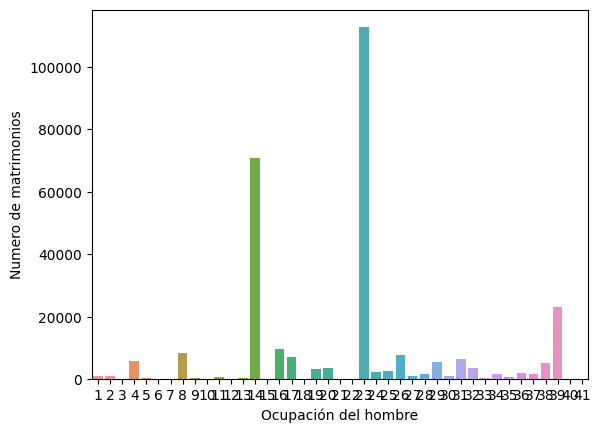

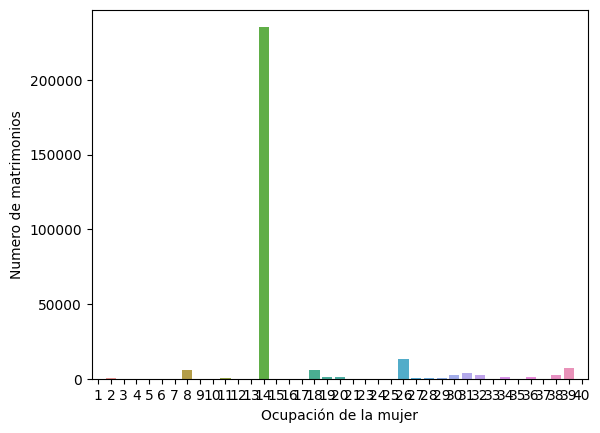

In [20]:
sns.countplot(x='ocupacionHombre', data=data_final)
plt.xlabel('Ocupación del hombre')
plt.ylabel('Numero de matrimonios')
plt.show()

sns.countplot(x='ocupacionMujer', data=data_final)
plt.xlabel('Ocupación de la mujer')
plt.ylabel('Numero de matrimonios')
plt.show()

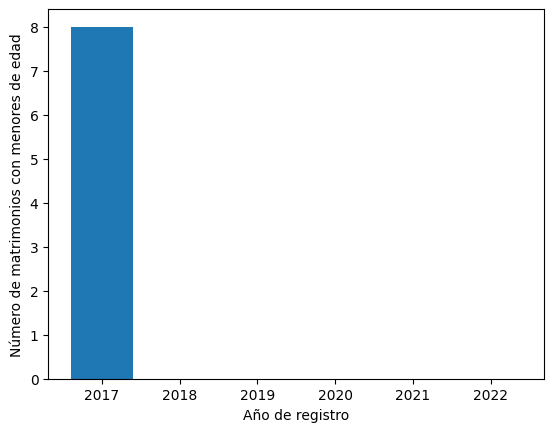

In [33]:
# Cantidad de matrimonios con menores de edad por año
df_temp = data_final.copy()

df_temp['conMenores'] = ((df_temp['edadHombre'] < 18) | (df_temp['edadMujer'] < 18)).astype(int)
new_df = df_temp.groupby('anioRegistro')['conMenores'].sum().reset_index()

plt.bar(new_df['anioRegistro'], new_df['conMenores'])
plt.xlabel('Año de registro')
plt.ylabel('Número de matrimonios con menores de edad')
plt.show()

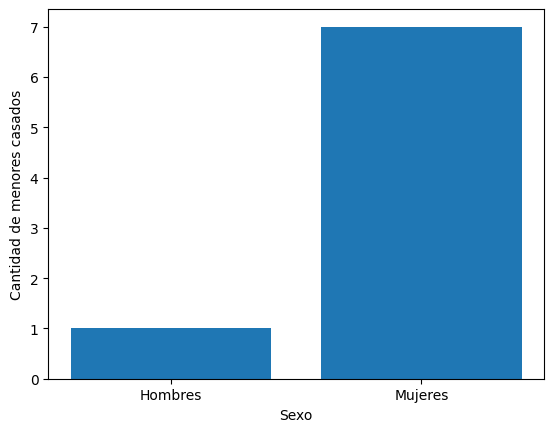

In [42]:
# Cantidad de hombres y mujeres casados menores de 18 años
men = data_final[data_final['edadHombre'] < 18]
women = data_final[data_final['edadMujer'] < 18]

plt.bar(["Hombres", "Mujeres"], [len(men), len(women)])
plt.xlabel('Sexo')
plt.ylabel('Cantidad de menores casados')
plt.show()

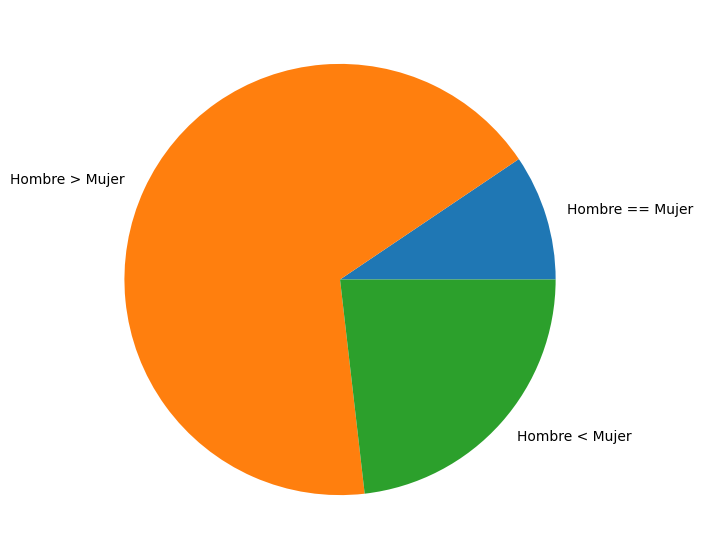

In [41]:
# Porcentaje de matrimonios donde uno es menor de edad
same_age = data_final[data_final['edadHombre'] == data_final['edadMujer']]

man_upper = data_final[data_final['edadHombre'] > data_final['edadMujer']]

woman_upper = data_final[data_final['edadHombre'] < data_final['edadMujer']]

labels = ["Hombre == Mujer", "Hombre > Mujer", "Hombre < Mujer"]

data = [len(same_age), len(man_upper), len(woman_upper)]

fig = plt.figure(figsize =(10, 7))
plt.pie(data, labels = labels)
 
plt.show() # show plot

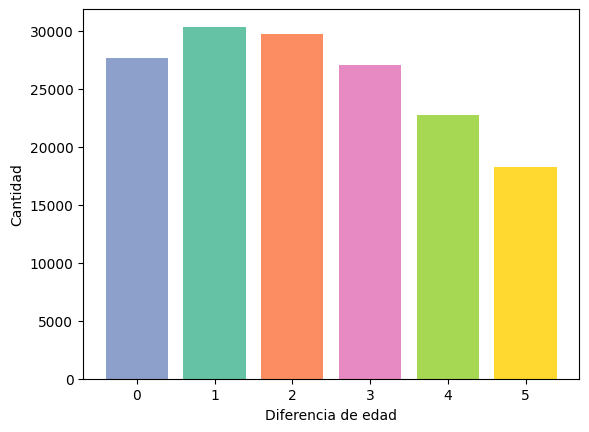

In [84]:
# Cantidad de diferencia de edad
df_temp = data_final.copy()

df_temp['difference'] = df_temp["edadHombre"] - df_temp["edadMujer"]
df_temp = df_temp[df_temp['difference'] >= 0].sort_values(by='difference', ascending=True)
result = df_temp['difference'].value_counts().head(6)

palette = sns.color_palette('Set2', n_colors=len(result))

plt.bar(result.index, result.values, color=palette)
plt.xlabel('Diferencia de edad')
plt.ylabel('Cantidad')
plt.show()

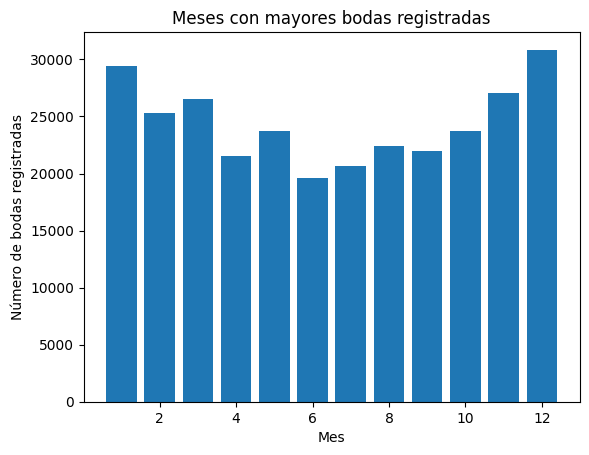

In [88]:
# Meses con mayores bodas registradas
result = data_final['mesOcurrencia'].value_counts()

plt.bar(result.index, result.values)
plt.xlabel('Mes')
plt.ylabel('Número de bodas registradas')
plt.title('Meses con mayores bodas registradas')
plt.show()

## Coeficiente de Hopksins

In [22]:
import random, sklearn, pyclustertend

random.seed(123)
X_scale = sklearn.preprocessing.scale(data_final)

# pyclustertend.hopkins(X_scale, len(X_scale))


El valor del coeficiente de Hopkins es 0.10038441320982114 lo cual indica que los datos se pueden agrupar de forma efectiva.

## Gráfico de codo

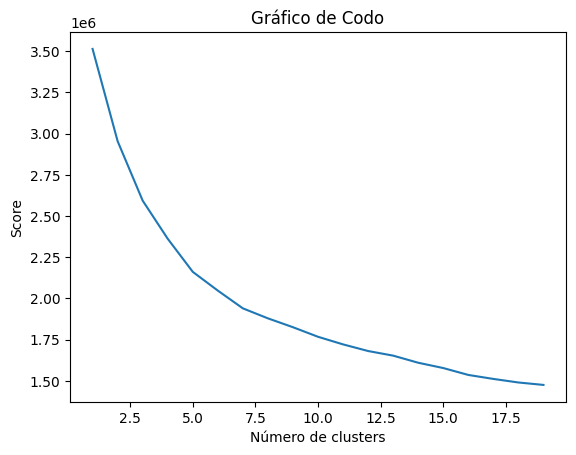

In [23]:
numeroClusters = range(1,20)
wcss = []
for i in numeroClusters:
    kmeans = cluster.KMeans(n_clusters=i)
    kmeans.fit(X_scale)
    wcss.append(kmeans.inertia_)

plt.plot(numeroClusters, wcss)
plt.xlabel("Número de clusters")
plt.ylabel("Score")
plt.title("Gráfico de Codo")
plt.show()